# Exploratory Analysis
This notebook contains the exploratory analysis that will be developed on to produce models.

### Imports

In [1]:
import datahandler.JHU
import datahandler.WorldBank

import datetime as dt
import numpy as np
import pandas as pd

In [2]:
import plotly.io as pio
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [3]:
'+'.join([pio.renderers.default, "iframe"])

'plotly_mimetype+notebook+iframe'

In [4]:
pio.renderers.default = pio.renderers.default + "+iframe"

## High-level examination

In [5]:
country_level_data = datahandler.JHU.global_case_data()

In [6]:
latest_wb_pop = datahandler.WorldBank.latest_worldbank("SP.POP.TOTL")

First we look at the current top-level global trend.

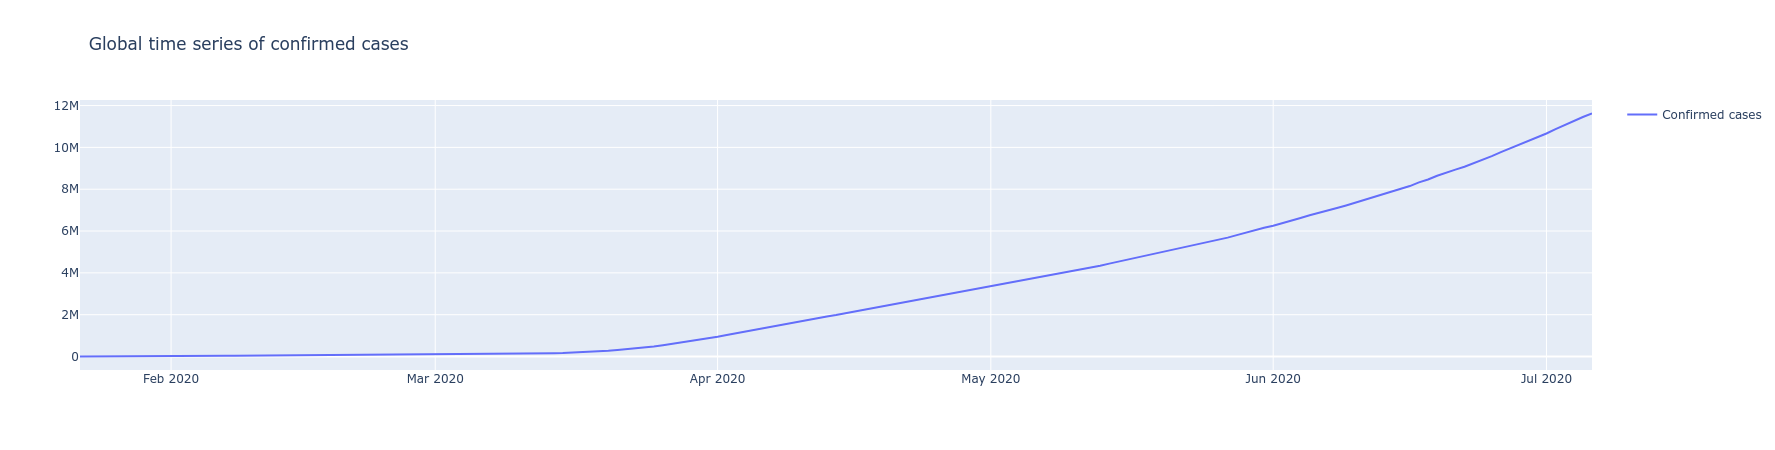

In [7]:
import plotly.graph_objects as go

fig = go.Figure(data = go.Scatter(x=country_level_data.index,
                                   y=country_level_data.sum(axis=1),
                                   name='Confirmed cases'
                                  )
               ).update_layout(title='Global time series of confirmed cases',
                               showlegend=True
                              )
fig.show()

Overall, the graph seems to be climbing steadily, possibly exponential at first, then linear? We will therefore plot a log-graph of the cases. An exponential trend should be approximately linear on a log-graph, while a linear trend would appear logarithmic (as all things should be).

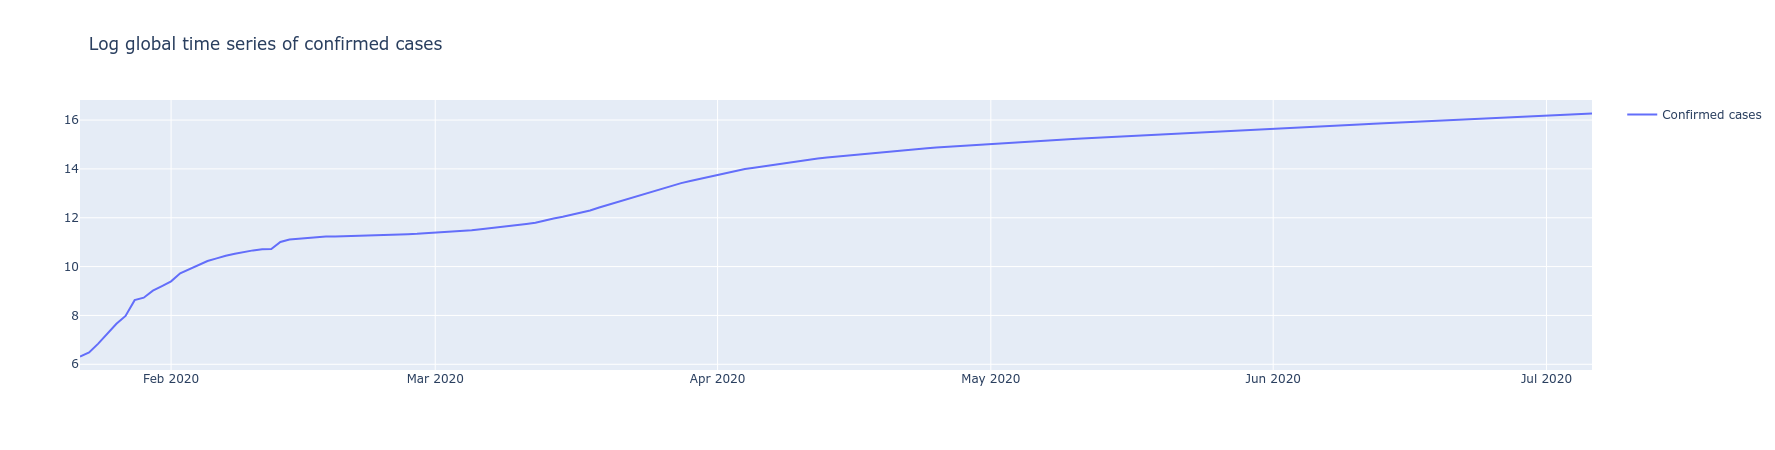

In [8]:
fig = go.Figure(data = go.Scatter(x=country_level_data.index,
                                   y=np.log(country_level_data.sum(axis=1)),
                                   name='Confirmed cases'
                                  )
               ).update_layout(title='Log global time series of confirmed cases',
                               showlegend=True
                              )
fig.show()

The logarithmic graph shows a few more interesting insights.

The initial period does appear linear, but it tails off almost linearly before experiencing a jump from 12 February to 13 February. This is of course due to the change in reporting that China adopted on that date. This gives us our first notice that we need to pay attention to such reporting discrepancies, especially since they add additional noise to the data.

The trend then starts to increase again, first linearly before a change in gradient around 12 March, when European countries started to experience their own exponential growth stage. This tails off again to a logarithmic trend after, at around the beginning of April. The trend thereafter is harder to discern visually. 

The overall trend is harder to discern, since it is comprised of different countries with their own infection patterns, with some countries/regions seeing infections rise at different times, e.g. the original spread in China vs the subsequent spread in Europe, and then in the Americas.

## Country-level breakdown
First, we try to align the case numbers meaningfully. 
### Day 0 alignment
In this case, we treat the last day on which there were no cases reported as day 0. 

In [9]:
country_level_data

Country/Region  Afghanistan  Albania  Algeria  Andorra  Angola  \
2020-01-22                0        0        0        0       0   
2020-01-23                0        0        0        0       0   
2020-01-24                0        0        0        0       0   
2020-01-25                0        0        0        0       0   
2020-01-26                0        0        0        0       0   
...                     ...      ...      ...      ...     ...   
2020-07-02            32022     2662    14657      855     315   
2020-07-03            32324     2752    15070      855     328   
2020-07-04            32672     2819    15500      855     346   
2020-07-05            32951     2893    15941      855     346   
2020-07-06            33190     2964    16404      855     346   

Country/Region  Antigua and Barbuda  Argentina  Armenia  Australia  Austria  \
2020-01-22                        0          0        0          0        0   
2020-01-23                        0          0        0          0        0   
2020-01-24                        0          0        0          0        0   
2020-01-25                        0          0        0          0        0   
2020-01-26                        0          0        0          4        0   
...                             ...        ...      ...        ...      ...   
2020-07-02                       69      69941    26658       8066    17941   
2020-07-03                       68      72786    27320       8260    18050   
2020-07-04                       68      75376    27900       8443    18165   
2020-07-05                       68      77815    28606       8583    18280   
2020-07-06                       70      80447    28936       8755    18365   

Country/Region  ...  United Kingdom  Uruguay  Uzbekistan  Venezuela  Vietnam  \
2020-01-22      ...               0        0           0          0        0   
2020-01-23      ...               0        0           0          0        2   
2020-01-24      ...               0        0           0          0        2   
2020-01-25      ...               0        0           0          0        2   
2020-01-26      ...               0        0           0          0        2   
...             ...             ...      ...         ...        ...      ...   
2020-07-02      ...          285285      947        9078       6273      355   
2020-07-03      ...          285787      952        9396       6537      355   
2020-07-04      ...          286412      955        9708       6750      355   
2020-07-05      ...          286931      956       10020       7169      355   
2020-07-06      ...          287290      960       10362       7411      369   

Country/Region  West Bank and Gaza  Western Sahara  Yemen  Zambia  Zimbabwe  
2020-01-22                       0               0      0       0         0  
2020-01-23                       0               0      0       0         0  
2020-01-24                       0               0      0       0         0  
2020-01-25                       0               0      0       0         0  
2020-01-26                       0               0      0       0         0  
...                            ...             ...    ...     ...       ...  
2020-07-02                    3080              10   1221    1632       617  
2020-07-03                    3334              10   1240    1632       625  
2020-07-04                    3835              10   1248    1632       698  
2020-07-05                    4277              10   1265    1632       716  
2020-07-06                    4341              10   1284    1632       734  

[167 rows x 188 columns]

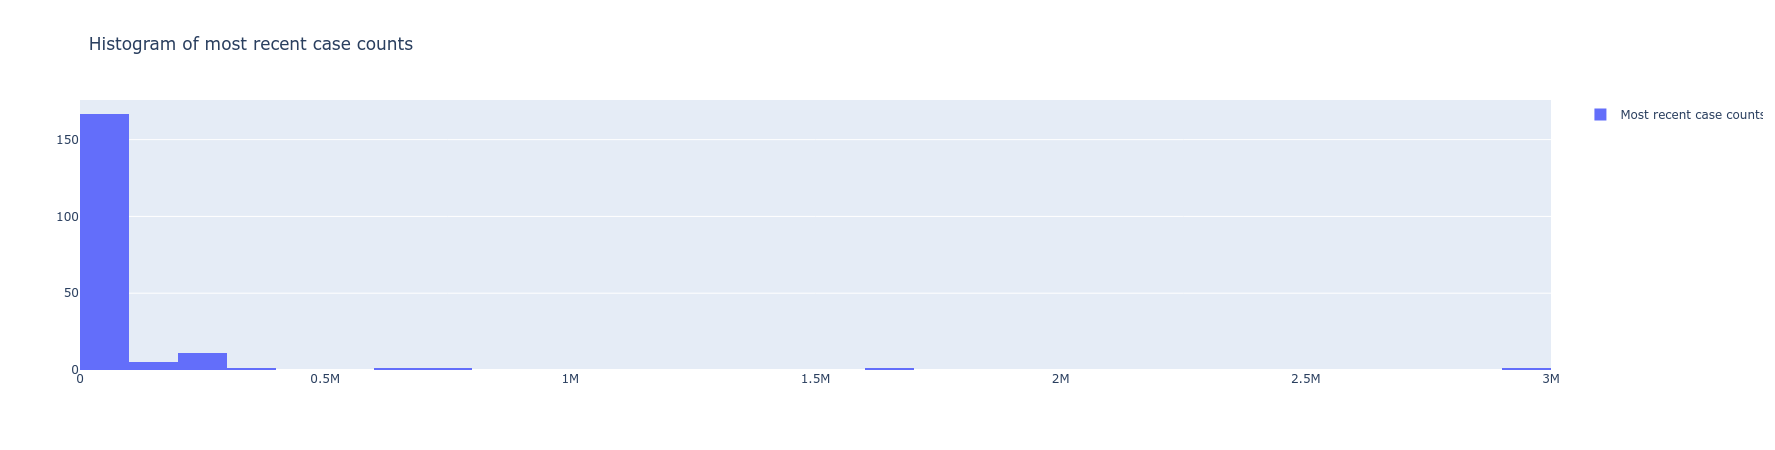

In [10]:
fig = go.Figure(data=[go.Histogram(x=country_level_data.iloc[-1, :],
                                   name='Most recent case counts'
                                  ),
                     ]).update_layout(title='Histogram of most recent case counts',
                                      showlegend=True
                                     )
fig.show()

In [11]:
def first_crossed(df, threshold):
    '''Takes a "tidy" dataframe and a threshold, and returns the date after which the values exceed the threshold.
    
    
    '''
    def inner_first_crossed(series, threshold):
        try:
            result = series[series > threshold].index[0]
            return result
        except IndexError:
            return np.nan
        
    result = df.apply(func=inner_first_crossed, args=[threshold]).dropna()
    return result

In [12]:
first_crossed(country_level_data, 1)

Country/Region
Afghanistan           2020-03-08
Albania               2020-03-09
Algeria               2020-03-02
Andorra               2020-03-16
Angola                2020-03-21
                         ...    
West Bank and Gaza    2020-03-05
Western Sahara        2020-04-05
Yemen                 2020-04-29
Zambia                2020-03-18
Zimbabwe              2020-03-21
Length: 188, dtype: object

In [13]:
def align_cases(df, threshold):
    '''
    
    '''
    temp = first_crossed(df, threshold)
    result = pd.DataFrame(data=[df[x][temp[x]-dt.timedelta(1):].values for x in temp.index]).transpose()
    result.columns = [x for x in temp.index]
    return result

In [14]:
align_cases(country_level_data, 1)

Afghanistan  Albania  Algeria  Andorra  Angola  Antigua and Barbuda  \
0            1.0      0.0      1.0      1.0     1.0                  1.0   
1            4.0      2.0      3.0      2.0     2.0                  3.0   
2            4.0     10.0      5.0     39.0     2.0                  3.0   
3            5.0     12.0     12.0     39.0     3.0                  3.0   
4            7.0     23.0     12.0     53.0     3.0                  7.0   
..           ...      ...      ...      ...     ...                  ...   
162          NaN      NaN      NaN      NaN     NaN                  NaN   
163          NaN      NaN      NaN      NaN     NaN                  NaN   
164          NaN      NaN      NaN      NaN     NaN                  NaN   
165          NaN      NaN      NaN      NaN     NaN                  NaN   
166          NaN      NaN      NaN      NaN     NaN                  NaN   

     Argentina  Armenia  Australia  Austria  ...  United Kingdom  Uruguay  \
0          1.0      1.0        0.0      0.0  ...             0.0      0.0   
1          2.0      4.0        4.0      2.0  ...             2.0      4.0   
2          8.0      8.0        5.0      2.0  ...             2.0      6.0   
3         12.0     18.0        5.0      3.0  ...             2.0      8.0   
4         12.0     26.0        6.0      3.0  ...             8.0     29.0   
..         ...      ...        ...      ...  ...             ...      ...   
162        NaN      NaN     8583.0      NaN  ...             NaN      NaN   
163        NaN      NaN     8755.0      NaN  ...             NaN      NaN   
164        NaN      NaN        NaN      NaN  ...             NaN      NaN   
165        NaN      NaN        NaN      NaN  ...             NaN      NaN   
166        NaN      NaN        NaN      NaN  ...             NaN      NaN   

     Uzbekistan  Venezuela  Vietnam  West Bank and Gaza  Western Sahara  \
0           1.0        0.0      0.0                 0.0             0.0   
1           6.0        2.0      2.0                 4.0             4.0   
2          10.0       10.0      2.0                 7.0             4.0   
3          15.0       17.0      2.0                16.0             4.0   
4          23.0       33.0      2.0                16.0             4.0   
..          ...        ...      ...                 ...             ...   
162         NaN        NaN    355.0                 NaN             NaN   
163         NaN        NaN    355.0                 NaN             NaN   
164         NaN        NaN    355.0                 NaN             NaN   
165         NaN        NaN    355.0                 NaN             NaN   
166         NaN        NaN    369.0                 NaN             NaN   

     Yemen  Zambia  Zimbabwe  
0      1.0     0.0       1.0  
1      6.0     2.0       3.0  
2      6.0     2.0       3.0  
3      7.0     2.0       3.0  
4     10.0     2.0       3.0  
..     ...     ...       ...  
162    NaN     NaN       NaN  
163    NaN     NaN       NaN  
164    NaN     NaN       NaN  
165    NaN     NaN       NaN  
166    NaN     NaN       NaN  

[167 rows x 188 columns]

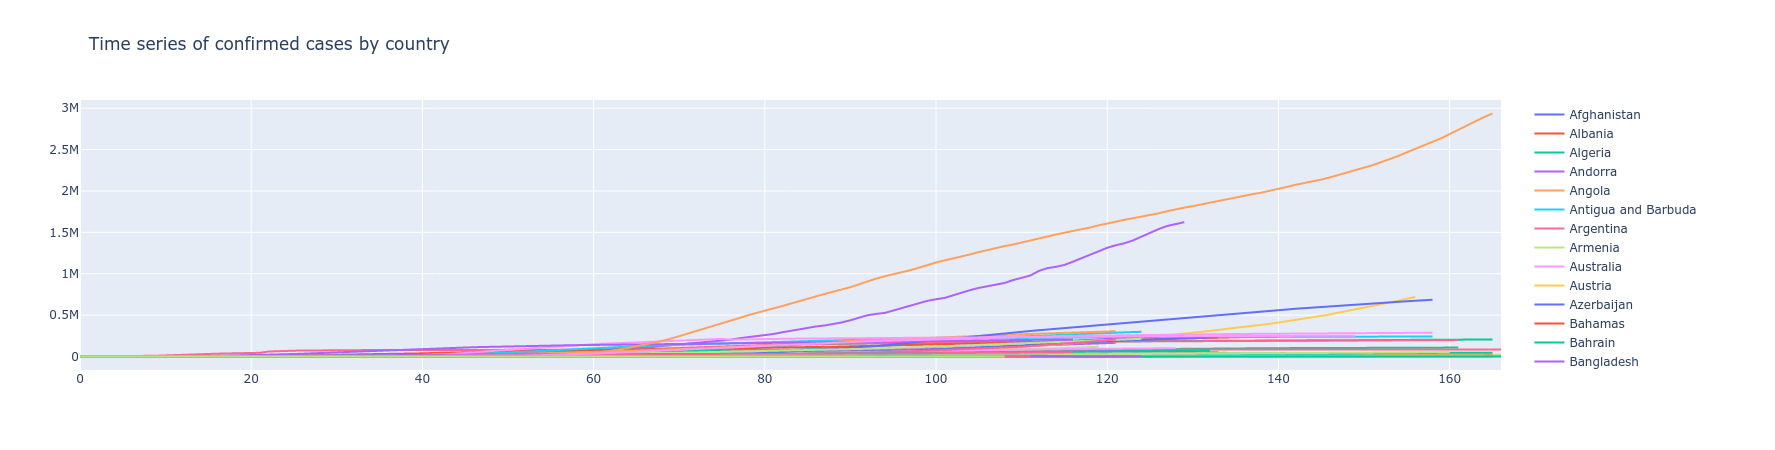

In [15]:
#def generate_scatter_from_column

aligned_1 = align_cases(country_level_data, 1)

fig = go.Figure(data = [go.Scatter(x=aligned_1.index,
                                   y=aligned_1[country].values,
                                   name=country
                                  ) for country in aligned_1.columns]
               ).update_layout(title='Time series of confirmed cases by country',
                               showlegend=True
                              )
fig.show()

The graph appears to show 2 outlier paths, as is rather well known, in the form of the US and Brazil. Apart from that however, most paths are fairly shallow. At this point, fitting a simple linear model regressing on past values would be of interest, as a baseline. While we would expect it to be far out, it can serve as the basis for more sophisticated models.

#### Linear model
This section makes the following assumptions:
* There are no population differences between countries.
    * While this is demonstrably false, a correction requires at the minimum a regression for each country, or additional population information (which will be introduced in later models).
* 2 weeks is sufficient data (the incubation period tends to be around 2 weeks or less). 
* That the dataset starts after some countries have already had cases recorded doesn't matter, since it's mostly the sequences that matter.

This section therefore aims to take the following steps:
1. Create the dataset for the regression.
    * While this is a straightforward model and may not require a validation set, one will be set up anyway so that other models (e.g. cross-validation) can be trained, and used for evaluation on the test set.
    * An arbitrary 60-20-20 split will be used for the train-validation-test split.
        * Because the split involves a time series, the split will have to take place in sequential order (train set before validation, validation set before test), so that the model can retain its usefulness for prediction of future values.
            * The data will be split for each country first, before being added together, to preserve the balance of classes (again, for potential future use).
2. Fit the model on the training set.
3. Test the model on the test set, collecting the MSE.

In [16]:
def train_val_test_split(df, seq_length: int):
    '''Splits the input dataframe into train, validation, and test. This function first defines an inner function that operates on a column, returning three dataframes containing the respective sets.
    '''
    def _process_column(df, seq_length: int, col: str):
        print(f"Processing: {col}")
        temp = df[col].dropna()
        n = len(temp) - seq_length + 1
        result = [temp[x:x+seq_length] for x in range(n)]
        test_len = int(n/5)
        train_len = n - (2 * test_len)
        return (result[:train_len], result[train_len:train_len+test_len], result[train_len+test_len:])
    
    train_set = []
    val_set = []
    test_set = []
    
    for col in df.columns:
        train_temp, val_temp, test_temp = _process_column(df, seq_length, col)
        train_set += train_temp
        val_set += val_temp
        test_set += test_temp
        
    train_set = pd.DataFrame([x.reset_index(drop=True) for x in train_set])
    val_set = pd.DataFrame([x.reset_index(drop=True) for x in val_set])
    test_set = pd.DataFrame([x.reset_index(drop=True) for x in test_set])
    return train_set, val_set, test_set

In [17]:
train_df, val_df, test_df = train_val_test_split(aligned_1, 14)
train_val_df = train_df.append(val_df)

Processing: Afghanistan
Processing: Albania
Processing: Algeria
Processing: Andorra
Processing: Angola
Processing: Antigua and Barbuda
Processing: Argentina
Processing: Armenia
Processing: Australia
Processing: Austria
Processing: Azerbaijan
Processing: Bahamas
Processing: Bahrain
Processing: Bangladesh
Processing: Barbados
Processing: Belarus
Processing: Belgium
Processing: Belize
Processing: Benin
Processing: Bhutan
Processing: Bolivia
Processing: Bosnia and Herzegovina
Processing: Botswana
Processing: Brazil
Processing: Brunei
Processing: Bulgaria
Processing: Burkina Faso
Processing: Burma
Processing: Burundi
Processing: Cabo Verde
Processing: Cambodia
Processing: Cameroon
Processing: Canada
Processing: Central African Republic
Processing: Chad
Processing: Chile
Processing: China
Processing: Colombia
Processing: Comoros
Processing: Congo (Brazzaville)
Processing: Congo (Kinshasa)
Processing: Costa Rica
Processing: Cote d'Ivoire
Processing: Croatia
Processing: Cuba
Processing: Cyprus

In [18]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

regr = linear_model.LinearRegression()
regr.fit(train_df.iloc[:, :-1], train_df.iloc[:, -1])

LinearRegression()

In [19]:
train_y_pred = regr.predict(train_df.iloc[:, :-1])
print(f"Training set MSE: {mean_squared_error(train_df.iloc[:, -1], train_y_pred)}")
print(f"Training set R^2: {r2_score(train_df.iloc[:, -1], train_y_pred)}")

Training set MSE: 204133.01754197068
Training set R^2: 0.9999223226987418


In [20]:
test_y_pred = regr.predict(test_df.iloc[:, :-1])
print(f"Test set MSE: {mean_squared_error(test_df.iloc[:, -1], test_y_pred)}")
print(f"Test set R^2: {r2_score(test_df.iloc[:, -1], test_y_pred)}")

Test set MSE: 1175795.5387032554
Test set R^2: 0.9999792146875154


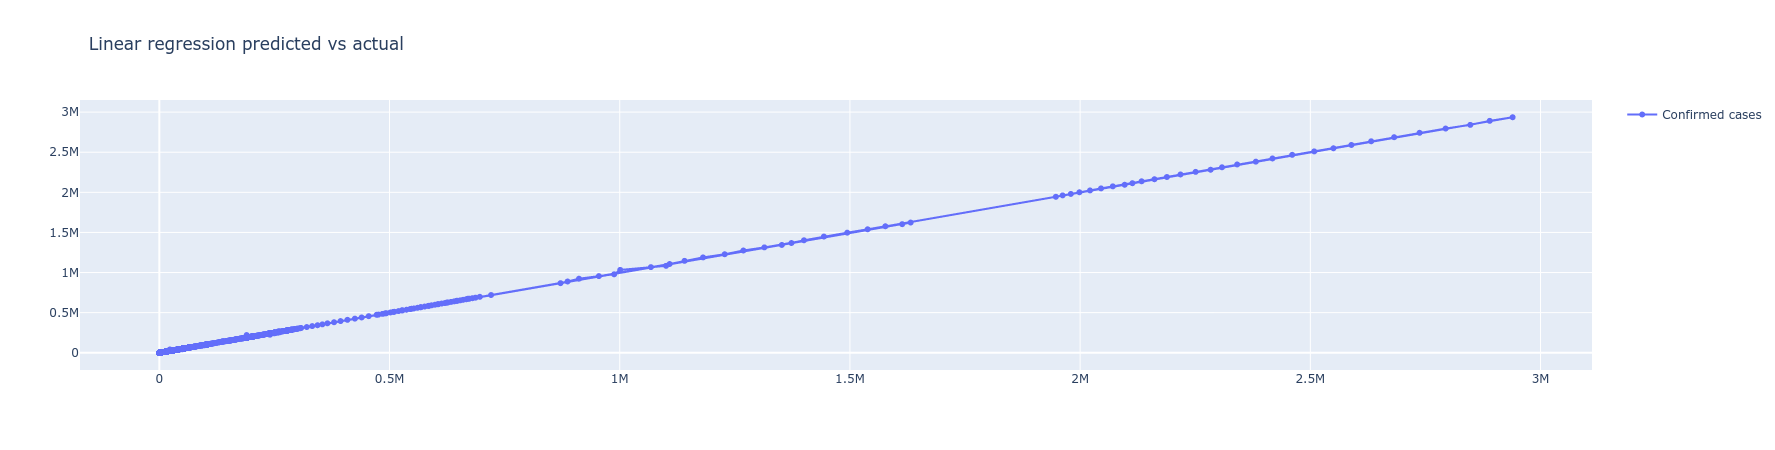

In [21]:
fig = go.Figure(data = go.Scatter(x=test_y_pred,
                                  y=test_df.iloc[:, -1],
                                  mode='lines+markers',
                                  name='Confirmed cases'
                                 )
               ).update_layout(title='Linear regression predicted vs actual',
                               showlegend=True
                              )
fig.show()

Immediately, a problem can be noticed. $R^2$ and MSE do not seem to be very good metrics to use to evaluate the suitability of this regression model. The MSE would be heavily biased by the larger values, as a missed prediction of 1% would be vastly different for predicted values of 1,000 (10), vs 1,000,000 (10,000). In this case, given that the case count is expected to keep increasing, with a range of case counts from the low hundreds to the millions, the MSE could mask the problems with predictions of lower values. If this is the case, we need to find a metric which will measure the value of the error relative to the value of the actual/predicted counts.

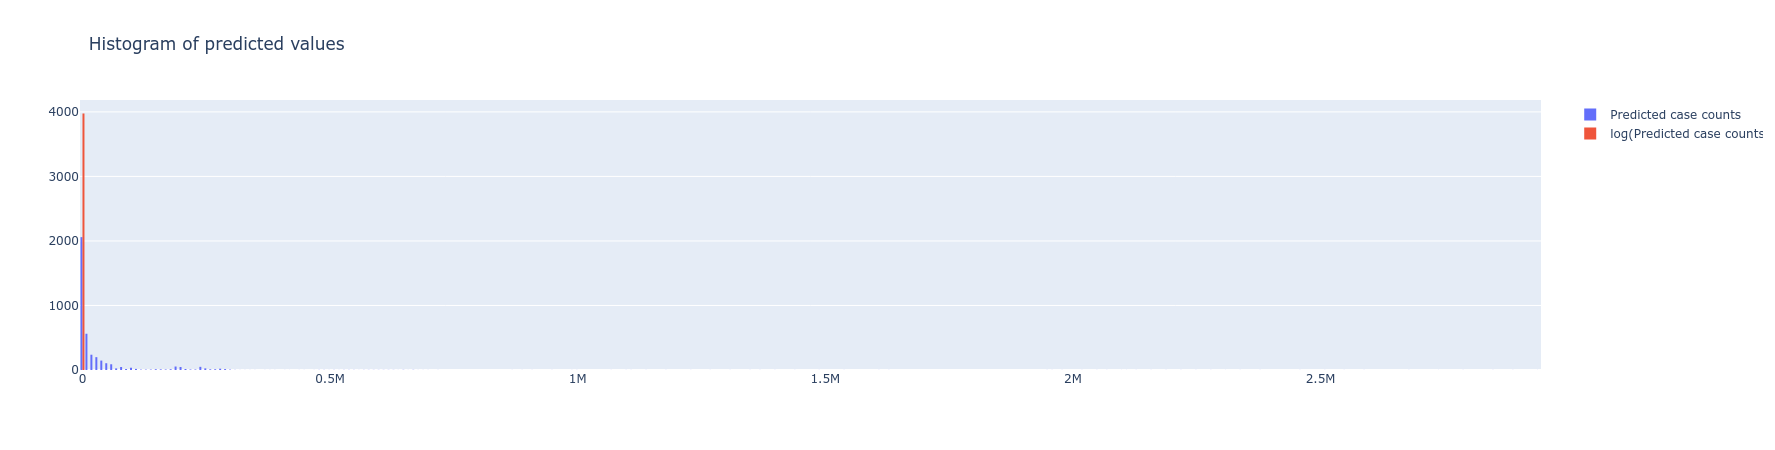

In [22]:
fig = go.Figure(data=[go.Histogram(x=test_y_pred,
                                   name='Predicted case counts'
                                  ),
                      go.Histogram(x=np.log(test_y_pred),
                                  name='log(Predicted case counts)'
                                  )
                     ]).update_layout(title='Histogram of predicted values',
                                      showlegend=True
                                     )
fig.show()

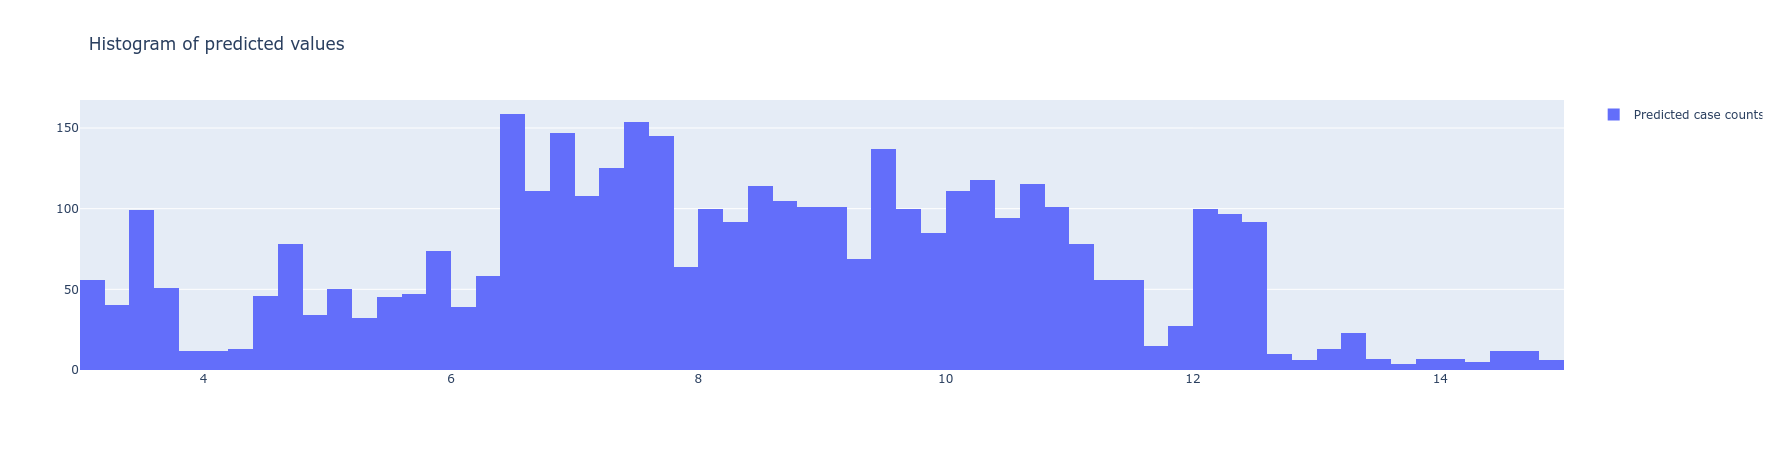

In [23]:
fig = go.Figure(data=[go.Histogram(x=np.log(test_y_pred),
                                   name='Predicted case counts'
                                  )]).update_layout(title='Histogram of predicted values',
                                                    showlegend=True
                                                   )
fig.show()

The histogram suggests that the predicted values are approximately exponentially distributed. This suggests the use of the mean squared log error (MSLE):

$$ \text{MSLE}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2. $$

According to the [scikit-learn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error), the mean squared log error _"is best to use when targets having exponential growth, such as population counts, average sales of a commodity over a span of years etc."_ This is indeed the current use-case, where the dependent variable is a population count, and is monitored over time, with exponential growth as seen above.

The use of the MSLE also brings other advantages, such as a higher penalisation of under-prediction as opposed to over-prediction, due to the nature of the logarithmic function. It is also more robust to outliers, since once again, the logarithmic function reduces the effect of an outlier value.

In [24]:
print(f"Training set MSLE: {mean_squared_log_error(train_df.iloc[:, -1], train_y_pred)}")
print(f"Test set MSLE: {mean_squared_log_error(test_df.iloc[:, -1], test_y_pred)}")

Training set MSLE: 0.10233019526002102
Test set MSLE: 0.024048581446792727


Curiously, the error in the training set seems to be higher than the error in the test set.

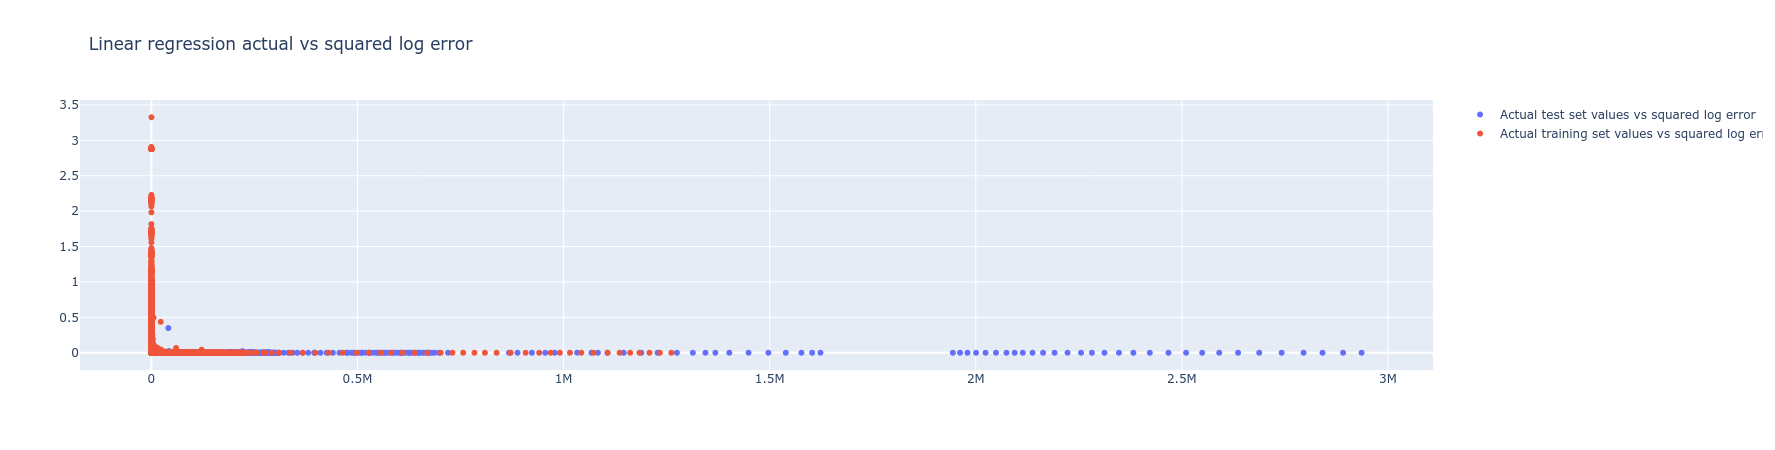

In [25]:
fig = go.Figure(data = [go.Scatter(x=test_df.iloc[:, -1],
                                   y=(np.log(1+test_df.iloc[:, -1]) - np.log(1+test_y_pred))**2,
                                   mode='markers',
                                   name='Actual test set values vs squared log error'
                                  ),
                        go.Scatter(x=train_df.iloc[:, -1],
                                   y=(np.log(1+train_df.iloc[:, -1]) - np.log(1+train_y_pred))**2,
                                   mode='markers',
                                   name='Actual training set values vs squared log error'
                                  )]
               ).update_layout(title='Linear regression actual vs squared log error',
                               showlegend=True
                              )
fig.show()

Plotting the values of the linear regression against the squared log error for both training set and test set (the plot can be manipulated above), it can be observed that the squared log error is highest for lower values. This suggests that the model is not doing well where case counts are much lower values, which would explain the lower test set error, since the training set contains values which are lower, since the training set consists of values preceding the test set values temporally.

This suggests that MSLE cannot be ruled out for comparison between models, which would be training and running on the same data. It also suggests that the simple linear regression model is not a very good model for smaller case counts. This model may however be used as a baseline, which will be doing going forward. As for its relevance with regards to prediction, by now, most countries have seen infections, and few are at levels low enough where the predictions may be a problem. Given the observations above, as time passes, we should in fact expect to see the error levels decrease. For a more directly comparable result however, we will have to train the model on both the training set and the validation set, then predict on the test set in order to obtain its results for a better basis of comparison, as we will be training all models on a concatenation of the training set to the validation set once selected.

A major theoretical issue with using this model however, is that the observations are required to be independent and identically distributed (i.i.d.). However, this is not the case here, as the dataset is cobbled together from past observations of case counts from all countries. This violates the assumption doubly:
* Observations from different countries may not (and are probably not) i.i.d.
    * This point is in fact utilised later by introducing country-specific data, such as population count, urbanisation measures, and lockdown control measures.
* By the nature of the chosen features, we are explicitly searching for a correlation between past values and future values.
    * The next model we explore in fact, will explore this relationship further.

In [26]:
regr_test = linear_model.LinearRegression()
regr_test.fit(train_val_df.iloc[:, :-1], train_val_df.iloc[:, -1])

LinearRegression()

In [27]:
regr_test_y_pred = regr_test.predict(test_df.iloc[:, :-1])
print(f"Test set MSLE: {mean_squared_log_error(test_df.iloc[:, -1], regr_test_y_pred)}")

Test set MSLE: 0.02420823997245689


### Auto-correlation
Next, we examine the autocorrelation and partial autocorrelation functions of the data.

In [28]:
autocorr_df = {}
for col in aligned_1.columns:
    print(f"Processing: {col}")
    autocorr_df[col] = [aligned_1[col].diff().autocorr(lag=i) for i in range(aligned_1.dropna(axis=0).shape[0])] # truncate lags to maximum possible length
    
autocorr_df = pd.DataFrame(autocorr_df)#.dropna(axis=0)
autocorr_df

Processing: Afghanistan
Processing: Albania
Processing: Algeria
Processing: Andorra
Processing: Angola
Processing: Antigua and Barbuda
Processing: Argentina
Processing: Armenia
Processing: Australia
Processing: Austria
Processing: Azerbaijan
Processing: Bahamas
Processing: Bahrain
Processing: Bangladesh
Processing: Barbados
Processing: Belarus
Processing: Belgium
Processing: Belize
Processing: Benin
Processing: Bhutan
Processing: Bolivia
Processing: Bosnia and Herzegovina
Processing: Botswana
Processing: Brazil
Processing: Brunei
Processing: Bulgaria
Processing: Burkina Faso
Processing: Burma
Processing: Burundi
Processing: Cabo Verde
Processing: Cambodia
Processing: Cameroon
Processing: Canada
Processing: Central African Republic
Processing: Chad
Processing: Chile
Processing: China
Processing: Colombia
Processing: Comoros
Processing: Congo (Brazzaville)
Processing: Congo (Kinshasa)
Processing: Costa Rica
Processing: Cote d'Ivoire
Processing: Croatia
Processing: Cuba
Processing: Cyprus

/home/jay/anaconda3/envs/data-sandbox/lib/python3.8/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning:

Degrees of freedom <= 0 for slice

/home/jay/anaconda3/envs/data-sandbox/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning:

divide by zero encountered in true_divide



Processing: Maldives
Processing: Mali
Processing: Malta
Processing: Mauritania
Processing: Mauritius
Processing: Mexico
Processing: Moldova
Processing: Monaco
Processing: Mongolia
Processing: Montenegro
Processing: Morocco
Processing: Mozambique
Processing: Namibia
Processing: Nepal
Processing: Netherlands
Processing: New Zealand
Processing: Nicaragua
Processing: Niger
Processing: Nigeria
Processing: North Macedonia
Processing: Norway
Processing: Oman
Processing: Pakistan
Processing: Panama
Processing: Papua New Guinea
Processing: Paraguay
Processing: Peru
Processing: Philippines
Processing: Poland
Processing: Portugal
Processing: Qatar
Processing: Romania
Processing: Russia
Processing: Rwanda
Processing: Saint Kitts and Nevis
Processing: Saint Lucia
Processing: Saint Vincent and the Grenadines
Processing: San Marino
Processing: Sao Tome and Principe
Processing: Saudi Arabia
Processing: Senegal
Processing: Serbia
Processing: Seychelles
Processing: Sierra Leone
Processing: Singapore
Pro

Afghanistan   Albania   Algeria   Andorra    Angola  Antigua and Barbuda  \
0      1.000000  1.000000  1.000000  1.000000  1.000000             1.000000   
1      0.920073  0.886320  0.973261  0.452231  0.270638            -0.019436   
2      0.913713  0.854576  0.953959  0.501537  0.406557            -0.024758   
3      0.914360  0.833824  0.930649  0.511248  0.276810             0.074881   
4      0.901768  0.810670  0.898822  0.401308  0.192480            -0.006352   
5      0.903366  0.810635  0.867060  0.462824  0.400111            -0.024407   
6      0.861884  0.770251  0.827993  0.401870  0.314633            -0.022141   
7      0.848951  0.770593  0.781797  0.437865  0.380250            -0.022422   
8      0.837048  0.755409  0.740408  0.408982  0.157174            -0.024617   
9      0.813810  0.743818  0.679413  0.359002  0.218998            -0.022060   
10     0.798814  0.727195  0.607905  0.422313  0.251544            -0.016598   
11     0.783155  0.700145  0.545774  0.343311  0.261600             0.035075   
12     0.748193  0.705626  0.500351  0.295661  0.248127             0.003905   
13     0.733129  0.639651  0.455915  0.408408  0.291649            -0.042097   
14     0.686825  0.638239  0.419250  0.227460  0.421472            -0.042579   
15     0.672124  0.609012  0.384205  0.298143  0.518101            -0.008865   
16     0.633986  0.589449  0.347247  0.312215  0.306228            -0.017654   
17     0.591746  0.591749  0.319693  0.194161  0.548628            -0.041037   
18     0.577842  0.569690  0.290951  0.226945  0.207023            -0.012866   
19     0.539954  0.555155  0.258832  0.217804  0.256259            -0.013351   
20     0.515637  0.485139  0.229295  0.197426  0.410502            -0.029416   
21     0.494069  0.454013  0.217873  0.190500  0.276425            -0.029916   
22     0.466340  0.394699  0.196688  0.135562  0.352730            -0.040242   
23     0.456951  0.334537  0.180032  0.134805  0.144358            -0.040754   
24     0.408330  0.245376  0.161262  0.100028  0.097465            -0.029756   
25     0.371694  0.183857  0.159860  0.014900 -0.001390             0.070610   
26     0.380978  0.112201  0.164482  0.133216 -0.011300            -0.042371   
27     0.319894  0.068090  0.162807 -0.006122  0.179355            -0.031391   
28     0.296459 -0.006867  0.142157  0.056604  0.117652            -0.014631   
29     0.256482  0.018714  0.146057  0.044191  0.210882            -0.038340   
30     0.239184  0.063171  0.164113 -0.031822  0.087580            -0.036058   
31     0.211787  0.014897  0.181803  0.045315  0.059633            -0.044404   
32     0.187570 -0.045934  0.212852 -0.048043  0.058177            -0.045042   
33     0.189645 -0.083959  0.260873 -0.014437  0.183163            -0.048599   
34     0.140706 -0.100037  0.294687 -0.047202  0.532030            -0.046375   
35     0.126701 -0.094037  0.320544 -0.054197  0.242176            -0.047071   
36     0.110156 -0.134243  0.347567  0.013860  0.198692            -0.030335   
37     0.097578 -0.151990  0.365344 -0.067861  0.217284            -0.046674   
38     0.084052 -0.230033  0.394956  0.025142 -0.073703            -0.047405   
39     0.043142 -0.245801  0.418215  0.010405  0.279961            -0.039391   
40     0.011247 -0.233626  0.434716 -0.082058  0.217562            -0.047868   
41     0.028753 -0.214163  0.445807 -0.008055  0.229918            -0.048654   
42     0.010680 -0.271659  0.446608 -0.090559  0.128829            -0.049467   
43    -0.027555 -0.307199  0.445907 -0.048590 -0.064458            -0.050307   
44    -0.046319 -0.303129  0.443985  0.003396  0.197106            -0.051176   
45    -0.068236 -0.331178  0.435128 -0.008719 -0.092100            -0.052076   
46    -0.048534 -0.291535  0.430038  0.139083 -0.013777            -0.053008   

    Argentina   Armenia  Australia   Austria  ...  United Kingdom   Uruguay  \
0    1.000000  1.000000   1.000000  1.000000  ...        1.000000  1.000000   
1    

In [29]:
autocorr_df.dropna()

Afghanistan   Albania   Algeria   Andorra    Angola  Antigua and Barbuda  \
0     1.000000  1.000000  1.000000  1.000000  1.000000             1.000000   
1     0.920073  0.886320  0.973261  0.452231  0.270638            -0.019436   
2     0.913713  0.854576  0.953959  0.501537  0.406557            -0.024758   
3     0.914360  0.833824  0.930649  0.511248  0.276810             0.074881   
4     0.901768  0.810670  0.898822  0.401308  0.192480            -0.006352   

   Argentina   Armenia  Australia   Austria  ...  United Kingdom   Uruguay  \
0   1.000000  1.000000   1.000000  1.000000  ...        1.000000  1.000000   
1   0.984652  0.894048   0.857375  0.819116  ...        0.973943  0.476050   
2   0.972265  0.863535   0.870352  0.819696  ...        0.941354  0.391525   
3   0.962670  0.827484   0.812695  0.800724  ...        0.915195  0.349534   
4   0.959405  0.815095   0.808530  0.816917  ...        0.905494  0.215983   

   Uzbekistan  Venezuela   Vietnam  West Bank and Gaza  Western Sahara  \
0    1.000000   1.000000  1.000000            1.000000        1.000000   
1    0.881008   0.823833  0.439432            0.843167       -0.032878   
2    0.829382   0.846466  0.433883            0.774220       -0.033252   
3    0.846295   0.850881  0.431844            0.900086       -0.033634   
4    0.859653   0.794507  0.429077            0.866216       -0.034025   

      Yemen    Zambia  Zimbabwe  
0  1.000000  1.000000  1.000000  
1  0.362562 -0.034572  0.242524  
2  0.406709  0.238839  0.149969  
3  0.213108  0.156869  0.251693  
4  0.070880  0.091644  0.377350  

[5 rows x 188 columns]

One issue that we faced when first exploring this data, is that after dropping the autocorrelation function values which were NaN, we had 5 values left. We also had errors occurring randomly through the processing of calculating the ACF:
```
/anaconda3/envs/data-sandbox/lib/python3.8/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning:

Degrees of freedom <= 0 for slice

/anaconda3/envs/data-sandbox/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning:

divide by zero encountered in true_divide

```

We hypothesise that these may be due to poorer data available, e.g. on cruise ships or in countries which have only seen cases recently (and therefore have more limited data).

In [30]:
autocorr_drop = autocorr_df[autocorr_df.isna().any(axis=0)[autocorr_df.isna().any(axis=0)].index]

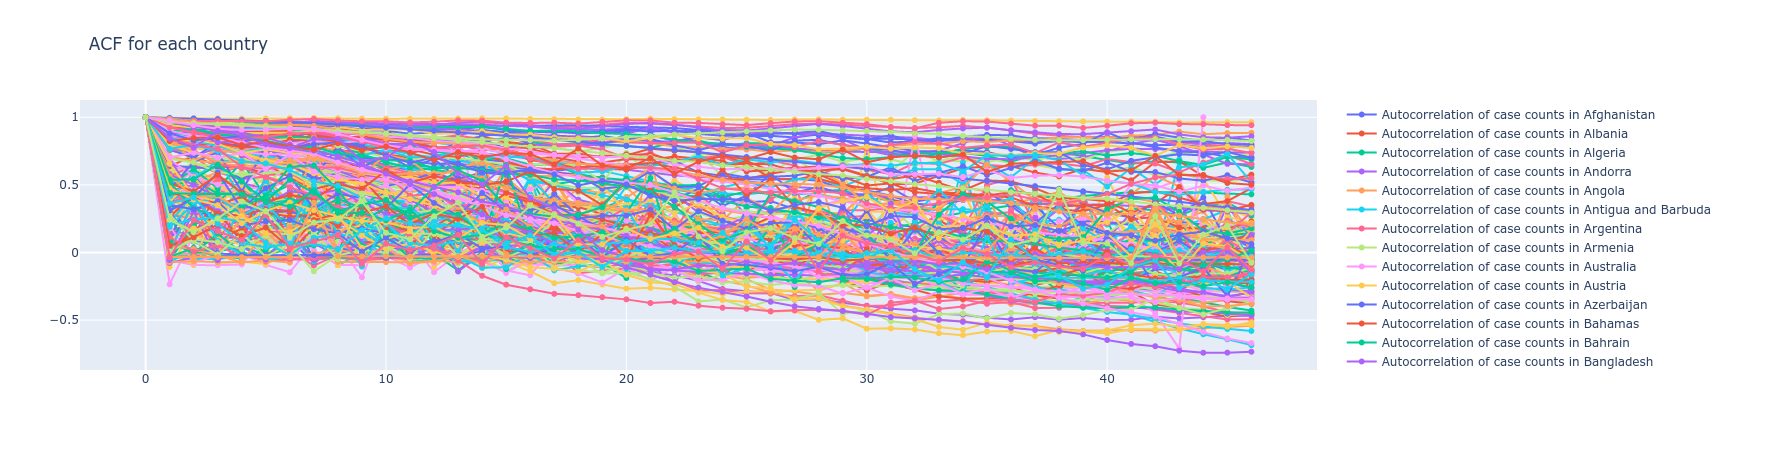

In [31]:
fig = go.Figure(data = [go.Scatter(y=autocorr_df[col],
                                   mode='lines+markers',
                                   name='Autocorrelation of case counts in ' + col
                                  ) for col in autocorr_df.columns]
               ).update_layout(title='ACF for each country',
                               showlegend=True
                              )
fig.show()

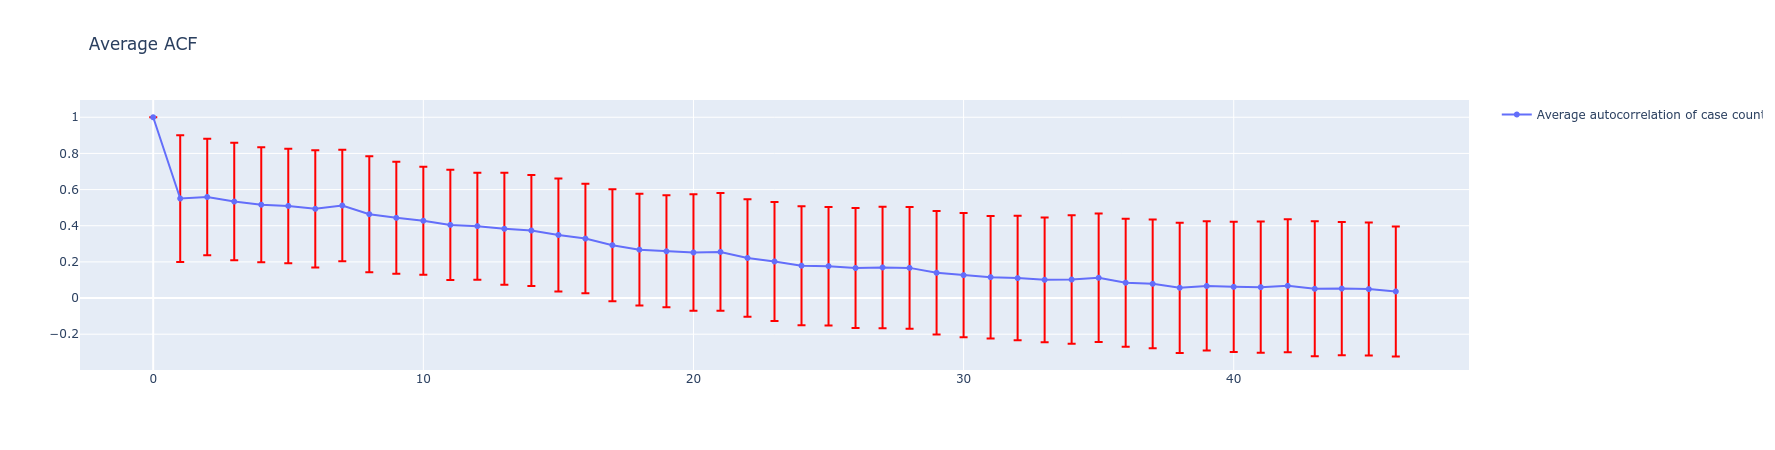

In [32]:
fig = go.Figure(data = go.Scatter(y=autocorr_df.mean(axis=1),
                                  mode='lines+markers',
                                  name='Average autocorrelation of case counts',
                                  error_y=dict(
                                      type='data',
                                      array=autocorr_df.std(axis=1),
                                      color='red',
                                      visible=True
                                  )
                                 )
               ).update_layout(title='Average ACF',
                              showlegend=True
                             )
fig.show()

The autocorrelations seem to be quite widely spread, and an ARIMA model or similar may not be effective at predicting the case counts. This also emphasises how the case counts for each country differ, and not including the idosyncrasies may result in reduced model performance.